In [1]:
import joblib
import numpy as np
from hyperopt import Trials
from torch.optim import Adam
from models.load_data import DataLoader
from models.RNN import StockLSTM, train, evaluate, validate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = 'data'
AAPL_TRAIN = 'aapl_train.csv'
AAPL_TEST = 'aapl_test.csv'
MSFT_TRAIN = 'msft_train.csv'
MSFT_TEST = 'msft_test.csv'

LOG_PATH = 'log'

In [3]:
def get_trials(dataset:str, model:str, mode:str) -> Trials:
    _model = 'StockLSTM' if model == 'lstm' else 'StockGRU'
    return joblib.load(f"{LOG_PATH}/{dataset}_{_model}_{mode}_optim.joblib")

In [6]:
trainLoader = DataLoader(f"{DATA_PATH}/{AAPL_TRAIN}",
                         look_back=24,
                         train=True,
                         valid_split=True,
                         valid_frac=0.3,
                         random_state=1234)
model = StockLSTM(40, 3)
optimizer = Adam(model.parameters(), lr=2e-3)
model, optimizer, record = train(model, trainLoader, epochs=500, batch_size=120, optimizer=optimizer, show_every=50)

Epoch 49/500: MSE = 0.43784159421920776
Epoch 99/500: MSE = 0.360445111989975
Epoch 149/500: MSE = 0.3414069712162018
Epoch 199/500: MSE = 0.33259275555610657
Epoch 249/500: MSE = 0.30042776465415955
Epoch 299/500: MSE = 0.2672238349914551
Epoch 349/500: MSE = 0.3021566569805145
Epoch 399/500: MSE = 0.21129170060157776
Epoch 449/500: MSE = 0.20104549825191498
Epoch 499/500: MSE = 0.23773202300071716
traing process finished in 28.407 seconds.
final MSE score = 0.23773202300071716


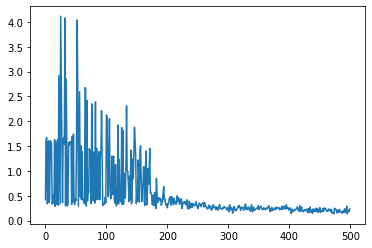

In [7]:
plt.plot(record[:, 0], record[:, 1])

lr: 2e-3 250轮
    1e-3 500轮
    5e-4 1500轮

自动调参时为确保收敛，使用 lr = 2e-3 训练400轮

运行 hyper_params.py 进行两阶段调参

第一阶段(model mode)：

固定 lr = 2e-3, batch_size = 120, epochs = 400

调参 look_back, hidden_dim, num_layers

第二阶段(train mode)：

选取一阶段中的最优参数，调参 lr, batch_size, epochs

最终最优参数如下：

In [4]:
epochs_pool = [400, 600, 800, 1000, 1200]
batch_size_pool = [100, 130, 160]

In [5]:
# AAPL_LSTM
t_m = get_trials('aapl', 'lstm', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('aapl', 'lstm', 'train')
print(f"epochs = {epochs_pool[t_t.argmin['epochs']]}")
print(f"batch_size = {batch_size_pool[t_t.argmin['batch_size']]}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid MSE = {t_t.average_best_error()}")

hidden_dim = 19
look_back = 28
num_layers = 1
epochs = 400
batch_size = 100
lr = 0.0006644794676094481

best valid MSE = 0.235263891518116


In [6]:
# AAPL_GRU
t_m = get_trials('aapl', 'gru', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('aapl', 'gru', 'train')
print(f"epochs = {epochs_pool[t_t.argmin['epochs']]}")
print(f"batch_size = {batch_size_pool[t_t.argmin['batch_size']]}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid MSE = {t_t.average_best_error()}")

hidden_dim = 12
look_back = 36
num_layers = 1
epochs = 400
batch_size = 160
lr = 0.0006769730028659444

best valid MSE = 0.22904129922389985


In [7]:
# MSFT_LSTM
t_m = get_trials('msft', 'lstm', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('msft', 'lstm', 'train')
print(f"epochs = {epochs_pool[t_t.argmin['epochs']]}")
print(f"batch_size = {batch_size_pool[t_t.argmin['batch_size']]}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid MSE = {t_t.average_best_error()}")

hidden_dim = 7
look_back = 2
num_layers = 1
epochs = 1200
batch_size = 160
lr = 0.0003448899547553008

best valid MSE = 0.3879301220178604


In [8]:
# MSFT_GRU
t_m = get_trials('msft', 'gru', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('msft', 'gru', 'train')
print(f"epochs = {epochs_pool[t_t.argmin['epochs']]}")
print(f"batch_size = {batch_size_pool[t_t.argmin['batch_size']]}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid MSE = {t_t.average_best_error()}")

hidden_dim = 17
look_back = 2
num_layers = 1
epochs = 1200
batch_size = 160
lr = 0.0005450900487765784

best valid MSE = 0.38768996894359586


两个数据集对应的最优模型，在全训练集上进行训练，并在测试集上评估

In [24]:
# AAPL_GRU
a_m = get_trials('aapl', 'gru', 'model').argmin
a_t = get_trials('aapl', 'gru', 'train').argmin
a_t['epochs'] = epochs_pool[a_t['epochs']]
a_t['batch_size'] = batch_size_pool[a_t['batch_size']]
trainLoader = DataLoader(f"{DATA_PATH}/{AAPL_TRAIN}", a_m['look_back'], random_state=2030)
model = StockLSTM(a_m['hidden_dim'], a_m['num_layers'])
# optimizer = Adam(model.parameters(), lr=a_t['lr'])
optimizer = Adam(model.parameters(), lr=2e-3)
# _, _, record = train(model, trainLoader, a_t['epochs'], a_t['batch_size'], optimizer, show_every=100)
_, _, record = train(model, trainLoader, 2000, a_t['batch_size'], optimizer, show_every=100)

Epoch 99/2000: MSE = 0.36684513092041016
Epoch 199/2000: MSE = 1.2695858478546143
Epoch 299/2000: MSE = 0.38801535964012146
Epoch 399/2000: MSE = 0.3157401978969574
Epoch 499/2000: MSE = 0.7653900384902954
Epoch 599/2000: MSE = 0.5454584360122681
Epoch 699/2000: MSE = 0.9712139964103699
Epoch 799/2000: MSE = 0.4450705945491791
Epoch 899/2000: MSE = 0.5879964232444763
Epoch 999/2000: MSE = 0.4426264762878418
Epoch 1099/2000: MSE = 0.4396640360355377
Epoch 1199/2000: MSE = 0.6214239001274109
Epoch 1299/2000: MSE = 0.27866873145103455
Epoch 1399/2000: MSE = 0.28781554102897644
Epoch 1499/2000: MSE = 0.2944934070110321
Epoch 1599/2000: MSE = 0.164839968085289
Epoch 1699/2000: MSE = 0.2620357573032379
Epoch 1799/2000: MSE = 0.18561838567256927
Epoch 1899/2000: MSE = 0.20507773756980896
Epoch 1999/2000: MSE = 0.1923747956752777
traing process finished in 36.991 seconds.
final MSE score = 0.1923747956752777


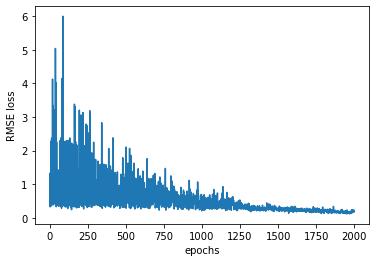

In [27]:
plt.xlabel('epochs')
plt.ylabel('RMSE loss')
plt.plot(record[:, 0], record[:, 1])

MSE = 0.12139508128166199


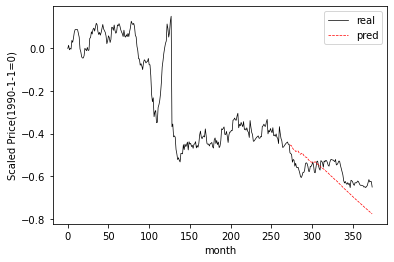

In [26]:
# 在测试集上评估
model.eval()
testLoader = DataLoader(
    f"{DATA_PATH}/{AAPL_TEST}",
    look_back=a_m['look_back'],
    train=False,
    train_params=trainLoader.getTrainParams(),
)
Xtest, ytest = testLoader.getTestData()
ypred = model.predict(Xtest, periods=len(ytest)).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

alldata = alldata.cumsum()
ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate(model, testLoader)}")

In [37]:
# MSFT_GRU
a_m = get_trials('msft', 'gru', 'model').argmin
a_t = get_trials('msft', 'gru', 'train').argmin
a_t['epochs'] = epochs_pool[a_t['epochs']]
a_t['batch_size'] = batch_size_pool[a_t['batch_size']]
trainLoader = DataLoader(f"{DATA_PATH}/{MSFT_TRAIN}", a_m['look_back'], random_state=2030)
model = StockLSTM(a_m['hidden_dim'], a_m['num_layers'])
# optimizer = Adam(model.parameters(), lr=a_t['lr'])
optimizer = Adam(model.parameters(), lr=2e-3)
# _, _, record = train(model, trainLoader, a_t['epochs'], a_t['batch_size'], optimizer, show_every=100)
_, _, record = train(model, trainLoader, 6000, a_t['batch_size'], optimizer, show_every=100)

Epoch 99/6000: MSE = 0.9697474241256714
Epoch 199/6000: MSE = 1.283506989479065
Epoch 299/6000: MSE = 0.9225829243659973
Epoch 399/6000: MSE = 1.1243587732315063
Epoch 499/6000: MSE = 0.9212681651115417
Epoch 599/6000: MSE = 0.6888962984085083
Epoch 699/6000: MSE = 0.8702734112739563
Epoch 799/6000: MSE = 0.6071726083755493
Epoch 899/6000: MSE = 0.7034448981285095
Epoch 999/6000: MSE = 1.4004945755004883
Epoch 1099/6000: MSE = 0.9813693761825562
Epoch 1199/6000: MSE = 0.9318265914916992
Epoch 1299/6000: MSE = 0.8786287307739258
Epoch 1399/6000: MSE = 0.7124605178833008
Epoch 1499/6000: MSE = 0.8846589922904968
Epoch 1599/6000: MSE = 1.0024089813232422
Epoch 1699/6000: MSE = 0.9820553064346313
Epoch 1799/6000: MSE = 1.058471441268921
Epoch 1899/6000: MSE = 0.5793753266334534
Epoch 1999/6000: MSE = 0.685017466545105
Epoch 2099/6000: MSE = 0.7290349006652832
Epoch 2199/6000: MSE = 0.7507994174957275
Epoch 2299/6000: MSE = 0.8551353216171265
Epoch 2399/6000: MSE = 0.8112179636955261
Epoch 

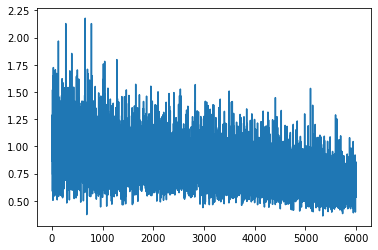

In [38]:
plt.plot(record[:, 0], record[:, 1])

MSE = 0.475075364112854


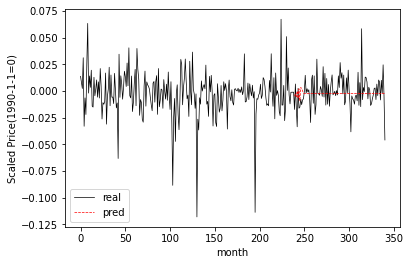

In [41]:
# 在测试集上评估
model.eval()
trainLoader = DataLoader(
    f"{DATA_PATH}/{MSFT_TRAIN}",
    look_back=a_m['look_back']
)
testLoader = DataLoader(
    f"{DATA_PATH}/{MSFT_TEST}",
    look_back=a_m['look_back'],
    train=False,
    train_params=trainLoader.getTrainParams(),
)
Xtest, ytest = testLoader.getTestData()
ypred = model.predict(Xtest, periods=len(ytest)).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

# alldata = alldata.cumsum()
# ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate(model, testLoader)}")

In [40]:
from sklearn.metrics import r2_score